In [3]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter
import requests
import random
from scipy import stats

Find wait times between mutations. Compare empirical data to expectation (that mutations should occur at a constant rate over time)

In [93]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [7]:
# import json
# json_fh = open('ncov_europe_2021-02-11.json', "r")
# json_dict = json.load(json_fh)
# test = json_to_tree(json_dict)

Assign each node a number of S1 mutations and RdRp that occurred at this node (rather than the accumulation)

In [94]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [95]:
for node in tree.find_clades():
    node.s1_muts_at_node = 0
    node.rdrp_muts_at_node = 0

    if hasattr(node, 'branch_attrs'):
        s1_muts_at_this_node = 0
        rdrp_muts_at_this_node = 0
        if 'S' in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]['S']:
                mut_pos = int(mut[1:-1])
                if mut_pos in range(14,686):
                    s1_muts_at_this_node+=1



        elif "ORF1a" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1a"]:
                if int(mut[1:-1]) in range(4492,4401):
                    rdrp_muts_at_this_node+=1

        elif "ORF1b" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1b"]:
                if int(mut[1:-1]) in range(1,923):
                    rdrp_muts_at_this_node+=1
                    
        # if there is more than one mutation on branch, assign each mutation a random date along the branch 
        

        node.s1_muts_at_node = s1_muts_at_this_node         
        node.rdrp_muts_at_node = rdrp_muts_at_this_node 


In [96]:
# find number of nodes that have S1 mutations
# only on internal branches
nodes_with_s1_muts = 0
total_s1_muts = 0

for node in tree.find_clades(terminal=False):
    if node.s1_muts_at_node!= 0:
        nodes_with_s1_muts+=1
        total_s1_muts += node.s1_muts_at_node
        
print(f'Nodes with S1 mutations: {nodes_with_s1_muts}')
print(f'Total number of S1 mutations: {total_s1_muts}')

# find number of nodes that have RdRp mutations
nodes_with_rdrp_muts = 0
total_rdrp_muts = 0

for node in tree.find_clades(terminal=False):
    # exclude this outlier
    if node.name != 'Kazakhstan/NRL-KZY-273S/2021':
        if node.rdrp_muts_at_node!= 0:
            nodes_with_rdrp_muts+=1
            total_rdrp_muts += node.rdrp_muts_at_node
        
print(f'Nodes with RdRp mutations: {nodes_with_rdrp_muts}')
print(f'Total number of RdRp mutations: {total_rdrp_muts}')

first_timepoint = tree.root.node_attrs['num_date']['value']
last_timepoint = 0
for node in tree.find_clades(terminal=False):
    if node.node_attrs['num_date']['value'] > last_timepoint:
        last_timepoint = node.node_attrs['num_date']['value']
        
print(f'Time window: {first_timepoint}-{last_timepoint}')
    

Nodes with S1 mutations: 240
Total number of S1 mutations: 342
Nodes with RdRp mutations: 41
Total number of RdRp mutations: 43
Time window: 2019.9779900962776-2021.4150684931508


Find the wait times between S1 (or RdRp) mutations. Do not double count paths between mutations. Mutations on parent brnaches can give rise to multiple wait times (see analog notebook for sketch)

In [97]:
# to deal with branches with multiple mutations, say that each mutation happens at a randomly chosen time 
# between the node and previous node


root_date = tree.root.node_attrs['num_date']['value']

# keep track of parts of paths that have already been considered
paths_segments_already_used_s1 = []

# keep track of nodes (with multiple S1 mutations) where the wait times 
# of 0 (between those mutations) have already been counted
wait_times_already_counted_at_node = []

# store all wait times between observed mutations
all_wait_times_s1 = []



for node in tree.find_clades(terminal=False):
    
    if node.name != 'Kazakhstan/NRL-KZY-273S/2021':
    
        node_path = get_parent(tree, node)
        
        # find the branch length (in decimal years) between node and previous node
        path_dates = [n.node_attrs['num_date']['value'] for n in node_path]
    
        if len(path_dates) > 0:
            path_dates_with_root = [root_date] + path_dates
            branch_lengths = [j-i for i, j in zip(path_dates_with_root[:-1], path_dates_with_root[1:])]

        s1_muts_on_path = [n.s1_muts_at_node for n in node_path]
        # indicies of branches that have S1 mutations
        s1_mut_indicies = [i for i, num_s1 in enumerate(s1_muts_on_path) if num_s1!=0]

        # count wait time from root until first mutation(s)
        if len(s1_mut_indicies) == 1:
            A_name = node_path[s1_mut_indicies[0]].name
            root_name = node_path[0].name

            if [root_name, A_name] not in paths_segments_already_used_s1:
                num_muts_A = s1_muts_on_path[s1_mut_indicies[0]]
                
                # pick date for branch A randomly between inferred node date and previous node 
                # because mutation happened somewhere in this time window, not necessarily right at the node
                node_date_A = node_path[s1_mut_indicies[0]].node_attrs['num_date']['value']
                
                # if there are multiple mutations at this branch, assign each of them a different random date
                dates_A = []
                for mut in range(num_muts_A):
                    date_A = random.uniform(node_date_A - branch_lengths[s1_mut_indicies[0]], node_date_A)
                    dates_A.append(date_A)
                    
                dates_A = sorted(dates_A)
                
                # prepend the root date
                dates_A = [root_date] + dates_A

                # find wait times between this branch and the root and between mutations on this branch
                wait_times = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]
                all_wait_times_s1+=wait_times

                paths_segments_already_used_s1.append([root_name, A_name])
                wait_times_already_counted_at_node.append(A_name)



        # if more than 1 mutation is on this path, calculate wait time between mutations
        if len(s1_mut_indicies) > 1:
            
            for x in range(len(s1_mut_indicies) -1):

                A_name = node_path[s1_mut_indicies[x]].name
                B_name = node_path[s1_mut_indicies[x+1]].name

                # only count wait times if this path segment hasn't already been counted
                if [A_name, B_name] not in paths_segments_already_used_s1:

                    num_muts_A = s1_muts_on_path[s1_mut_indicies[x]]
                    num_muts_B = s1_muts_on_path[s1_mut_indicies[x+1]]
                    
                    # pick dates for branches A and B randomly between inferred node date and previous node 
                    # because mutation happened somewhere in this time window, not necessarily right at the node
                    
                    
                    # if there are multiple mutations on these branch, assign each of them a different random date
                    node_date_A = node_path[s1_mut_indicies[x]].node_attrs['num_date']['value']
                    dates_A = []
                    for mut in range(num_muts_A):
                        date_A = random.uniform(node_date_A - branch_lengths[s1_mut_indicies[x]], node_date_A)
                        dates_A.append(date_A)

                    dates_A = sorted(dates_A)
                    
                    
                    node_date_B = node_path[s1_mut_indicies[x+1]].node_attrs['num_date']['value']
                    dates_B = []
                    for mut in range(num_muts_B):
                        date_B = random.uniform(node_date_B - branch_lengths[s1_mut_indicies[x+1]], node_date_B)
                        dates_B.append(date_B)

                    dates_B = sorted(dates_B)
                    

                    # find wait times between mutations on one branch
                    # only if this node hasn't already been counted
                    if A_name not in wait_times_already_counted_at_node:
                        wait_times_on_A = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]
                        all_wait_times_s1+=wait_times_on_A
                        wait_times_already_counted_at_node.append(A_name)
                        
                    if B_name not in wait_times_already_counted_at_node:
                        wait_times_on_B = [j-i for i, j in zip(dates_B[:-1], dates_B[1:])]
                        all_wait_times_s1+=wait_times_on_B
                        wait_times_already_counted_at_node.append(B_name)
                    
                    # and between latest mutation on branch A and earliest on branch B 
                    wait_time_between = dates_B[0] - dates_A[-1]
                    all_wait_times_s1.append(wait_time_between)



                    # add this pair of branches to the list of path segments that have already been counted
                    paths_segments_already_used_s1.append([A_name, B_name])






/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


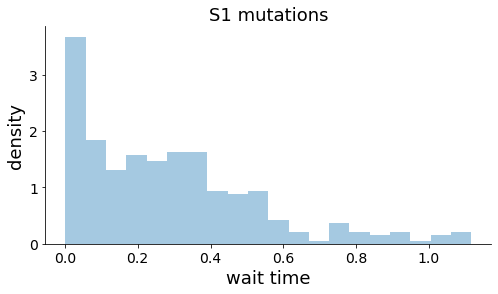

In [98]:
fig, ax = plt.subplots(figsize=(8,4))

# ax = sns.histplot(all_wait_times_s1, bins=20, color = "#1f78b4")
ax = sns.distplot(all_wait_times_s1, kde = False, norm_hist=True,  bins=20, color="#1f78b4")

ax.set_title('S1 mutations', fontsize = 18)
ax.set_xlabel('wait time', fontsize=18)
ax.set_ylabel('density', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
sns.despine(left=False, bottom=False)

Repeat this for RdRp mutations

In [99]:
root_date = tree.root.node_attrs['num_date']['value']

# keep track of parts of paths that have already been considered
paths_segments_already_used_rdrp = []

# keep track of nodes (with multiple S1 mutations) where the wait times 
# of 0 (between those mutations) have already been counted
wait_times_already_counted_at_node_rdrp = []

# store all wait times between observed mutations
all_wait_times_rdrp = []


for node in tree.find_clades(terminal=False):
    
    if node.name != 'Kazakhstan/NRL-KZY-273S/2021':

        node_path = get_parent(tree, node)
        
        # find the branch length (in decimal years) between node and previous node
        path_dates = [n.node_attrs['num_date']['value'] for n in node_path]
    
        if len(path_dates) > 0:
            path_dates_with_root = [root_date] + path_dates
            branch_lengths = [j-i for i, j in zip(path_dates_with_root[:-1], path_dates_with_root[1:])]

            
        rdrp_muts_on_path = [n.rdrp_muts_at_node for n in node_path]

        rdrp_mut_indicies = [i for i, num_rdrp in enumerate(rdrp_muts_on_path) if num_rdrp!=0]

        # count wait time from root until first mutation(s)
        if len(rdrp_mut_indicies) == 1:
            A_name = node_path[rdrp_mut_indicies[0]].name
            root_name = node_path[0].name

            if [root_name, A_name] not in paths_segments_already_used_rdrp:
                num_muts_A = rdrp_muts_on_path[rdrp_mut_indicies[0]]
                
                # pick date for branch A randomly between inferred node date and previous node 
                # because mutation happened somewhere in this time window, not necessarily right at the node                
                node_date_A = node_path[rdrp_mut_indicies[0]].node_attrs['num_date']['value']

                # if there are multiple mutations at this branch, assign each of them a different random date
                dates_A = []
                for mut in range(num_muts_A):
                    date_A = random.uniform(node_date_A - branch_lengths[rdrp_mut_indicies[0]], node_date_A)
                    dates_A.append(date_A)
                    
                dates_A = sorted(dates_A)
                
                # prepend the root date
                dates_A = [root_date] + dates_A

                # find wait times between this branch and the root and between mutations on this branch
                wait_times = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]
                all_wait_times_rdrp+=wait_times

                paths_segments_already_used_rdrp.append([root_name, A_name])
                wait_times_already_counted_at_node_rdrp.append(A_name)



        # only care if more than 1 mutation is on this path (to calculate wait time between mutations)
        if len(rdrp_mut_indicies) > 1:
            
            for x in range(len(rdrp_mut_indicies) -1):

                A_name = node_path[rdrp_mut_indicies[x]].name
                B_name = node_path[rdrp_mut_indicies[x+1]].name

                # only count wait times if this path segment hasn't already been counted
                if [A_name, B_name] not in paths_segments_already_used_rdrp:

                    num_muts_A = rdrp_muts_on_path[rdrp_mut_indicies[x]]
                    num_muts_B = rdrp_muts_on_path[rdrp_mut_indicies[x+1]]
                    
                    # pick dates for branches A and B randomly between inferred node date and previous node 
                    # because mutation happened somewhere in this time window, not necessarily right at the node
                    
                    
                    # if there are multiple mutations on these branch, assign each of them a different random date
                    node_date_A = node_path[rdrp_mut_indicies[x]].node_attrs['num_date']['value']
                    dates_A = []
                    for mut in range(num_muts_A):
                        date_A = random.uniform(node_date_A - branch_lengths[rdrp_mut_indicies[x]], node_date_A)
                        dates_A.append(date_A)

                    dates_A = sorted(dates_A)
                    
                    
                    node_date_B = node_path[rdrp_mut_indicies[x+1]].node_attrs['num_date']['value']
                    dates_B = []
                    for mut in range(num_muts_B):
                        date_B = random.uniform(node_date_B - branch_lengths[rdrp_mut_indicies[x+1]], node_date_B)
                        dates_B.append(date_B)

                    dates_B = sorted(dates_B)
                    

                    # find wait times between mutations on one branch
                    # only if this node hasn't already been counted
                    if A_name not in wait_times_already_counted_at_node_rdrp:
                        wait_times_on_A = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]
                        all_wait_times_rdrp+=wait_times_on_A
                        wait_times_already_counted_at_node_rdrp.append(A_name)
                        
                    if B_name not in wait_times_already_counted_at_node_rdrp:
                        wait_times_on_B = [j-i for i, j in zip(dates_B[:-1], dates_B[1:])]
                        all_wait_times_rdrp+=wait_times_on_B
                        wait_times_already_counted_at_node_rdrp.append(B_name)
                    
                    # and between latest mutation on branch A and earliest on branch B 
                    wait_time_between = dates_B[0] - dates_A[-1]
                    all_wait_times_rdrp.append(wait_time_between)

                    # add this pair of branches to the list of path segments that have already been counted
                    paths_segments_already_used_rdrp.append([A_name, B_name])






/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


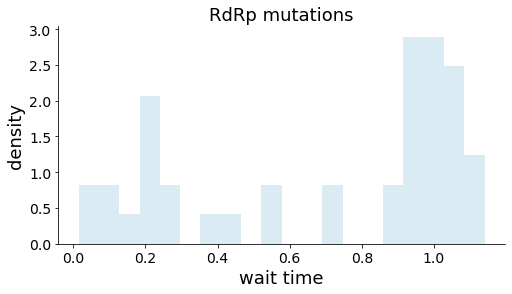

In [100]:
fig, ax = plt.subplots(figsize=(8,4))

# ax = sns.histplot(all_wait_times_rdrp, bins=20, color="#a6cee3")
ax = sns.distplot(all_wait_times_rdrp, kde = False, norm_hist=True, bins=20, color="#a6cee3")

ax.set_title('RdRp mutations', fontsize = 18)
ax.set_xlabel('wait time', fontsize=18)
ax.set_ylabel('density', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
sns.despine(left=False, bottom=False)

Expect mutations to occur at the same rate through time. Mutations are expected to accumulate via a Poisson process where wait times between mutations will be exponentially distributed

In [101]:
empirical_s1_mean = sum(all_wait_times_s1)/len(all_wait_times_s1)

# the mean of the wait time distribution should be equal to 1/lambda 
# where lambda is the rate of mutations in a Poisson process
s1_lambda = 1/empirical_s1_mean

In [76]:
deviations_s1 = [(x - empirical_s1_mean) ** 2 for x in all_wait_times_s1]
# Variance
variance_s1 = sum(deviations_s1) / len(all_wait_times_s1)

index_of_dispersion_s1 = variance_s1/empirical_s1_mean

print(variance)
print(1/(lambda_from_empirical**2))

0.06541752121974864
0.09256277723211485


In [102]:
empirical_rdrp_mean = sum(all_wait_times_rdrp)/len(all_wait_times_rdrp)

# the mean of the wait time distribution should be equal to 1/lambda 
# where lambda is the rate of mutations in a Poisson process
rdrp_lambda = 1/empirical_rdrp_mean

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


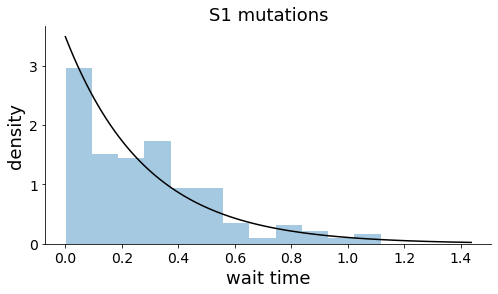

In [104]:
x = np.linspace(0, last_timepoint-first_timepoint, 100)
y = s1_lambda * np.exp(-s1_lambda * x)

fig, ax = plt.subplots(figsize=(8,4))

ax = sns.distplot(all_wait_times_s1, kde = False, norm_hist=True, color="#1f78b4")
plt.plot(x,y, color='black')

ax.set_title('S1 mutations', fontsize = 18)
ax.set_xlabel('wait time', fontsize=18)
ax.set_ylabel('density', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
sns.despine(left=False, bottom=False)

In [105]:
# total time in years
total_time = last_timepoint - first_timepoint

# pick occurrence times for each of the S1 mutations
random_dates = []
for x in range(total_s1_muts):
    random_dates.append(random.uniform(0,total_time))
    
random_dates = [0] + sorted(random_dates)

random_wait_times = [j-i for i, j in zip(random_dates[:-1], random_dates[1:])]

mean_random = sum(random_wait_times)/len(random_wait_times)
deviations_random = [(x - mean_random) ** 2 for x in random_wait_times]
# Variance
variance_random = sum(deviations_random) / len(random_wait_times)

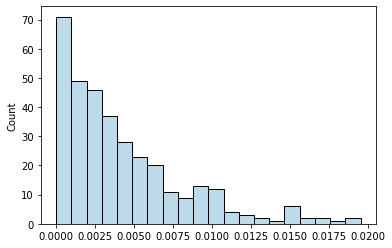

In [106]:
ax = sns.histplot(random_wait_times, bins=20, color="#a6cee3")